# Import

In [1]:
import os
import sys

import pickle
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import copy
import random
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import datetime
import time
from IPython.display import clear_output

from grace.utils import *

# Initialization

In [2]:
calib_params = load_json('config/calib/calib_params.json')

In [3]:
pan_direction: {
    0: 'left_left',
    1: 'left_right',
    2: 'right_left',
    3: 'right_right',
}
    
tilt_direction: {
    0: 'down_down',
    1: 'down_up',
    2: 'up_down',
    3: 'up_up',
}

In [4]:
def read_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

def get_phi_direction(theta, theta_tminus1, data, i):
    phi_direction = None
    if data[theta][i-1]<data[theta_tminus1][i-1] and data[theta][i]<data[theta_tminus1][i]:
        phi_direction = 0
    elif data[theta][i-1]<data[theta_tminus1][i-1] and data[theta][i]>=data[theta_tminus1][i]:
        phi_direction = 1
    elif data[theta][i-1]>=data[theta_tminus1][i-1] and data[theta][i]<data[theta_tminus1][i]:
        phi_direction = 2
    elif data[theta][i-1]>=data[theta_tminus1][i-1] and data[theta][i]>=data[theta_tminus1][i]:
        phi_direction = 3
    return phi_direction

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# Loading of Data

## Pickle Data

In [5]:
filename = 'baseline_fk_acc_pickle_20240113_185503_416265.pickle'

In [6]:
fn_path = os.path.join(os.getcwd(), 'results', 'baseline_fk_acc',filename)
data = read_pickle_file(fn_path)
data = data['data']

In [7]:
pickle_df = pd.DataFrame(data)
pickle_df.head()

,chess_idx,theta_left_pan,theta_right_pan,theta_tilt,chest_cam_px_x_tminus1,chest_cam_px_y_tminus1,left_eye_px_x_tminus1,left_eye_px_y_tminus1,right_eye_px_x_tminus1,right_eye_px_y_tminus1,...,plan_phi_right_pan,plan_phi_tilt,chest_img,left_eye_img,right_eye_img,depth_img,chest_img_stamp,left_eye_img_stamp,right_eye_img_stamp,depth_img_stamp
0,45,-10.107422,-11.425781,-27.773438,210.273483,105.885292,294.592804,98.950211,175.746307,103.928947,...,-0.375724,-0.236167,"[[[63, 52, 65], [63, 52, 65], [70, 50, 69], [7...","[[[37, 35, 31], [34, 33, 27], [34, 34, 25], [3...","[[[103, 141, 170], [104, 142, 171], [104, 143,...","[[3598, 3598, 3617, 3637, 3637, 3656, 3656, 36...",1.705141e+09,1.705141e+09,1.705141e+09,1.705141e+09
1,20,-11.513672,-12.480469,-29.531250,209.724319,233.191116,320.692169,207.707367,198.453873,215.764709,...,-0.297022,-0.111142,"[[[61, 42, 57], [64, 46, 60], [68, 48, 67], [7...","[[[35, 36, 36], [39, 40, 40], [36, 38, 40], [3...","[[[120, 196, 234], [120, 196, 234], [128, 201,...","[[3696, 3696, 3737, 3758, 3758, 3779, 3800, 38...",1.705141e+09,1.705141e+09,1.705141e+09,1.705141e+09
2,28,-9.140625,-10.283203,-16.259766,261.576111,156.462570,350.273438,192.488876,205.223160,200.211395,...,-0.338868,-0.155519,"[[[56, 46, 75], [55, 45, 74], [64, 51, 71], [6...","[[[59, 67, 71], [60, 68, 72], [61, 70, 71], [6...","[[[13, 21, 18], [14, 22, 20], [12, 22, 21], [1...","[[3676, 3676, 3696, 3717, 3717, 3717, 3737, 37...",1.705141e+09,1.705141e+09,1.705141e+09,1.705141e+09
3,30,-10.722656,-11.601562,-22.324219,235.680664,181.883728,328.026031,191.601654,199.878189,199.024612,...,-0.260473,-0.177380,"[[[76, 43, 66], [79, 46, 70], [73, 46, 73], [7...","[[[232, 255, 249], [228, 255, 249], [215, 255,...","[[[17, 26, 32], [19, 26, 32], [22, 28, 32], [2...","[[3637, 3637, 3637, 3637, 3617, 3579, 3579, 35...",1.705141e+09,1.705141e+09,1.705141e+09,1.705141e+09
4,28,-7.998047,-9.140625,-25.488281,287.344482,181.693649,358.615173,178.354340,211.162720,185.998856,...,-0.341015,-0.177380,"[[[80, 48, 81], [80, 48, 81], [66, 43, 77], [6...","[[[51, 52, 39], [49, 53, 39], [46, 51, 38], [4...","[[[54, 80, 92], [52, 75, 88], [61, 82, 95], [5...","[[3382, 3382, 3434, 3487, 3487, 3523, 3560, 35...",1.705141e+09,1.705141e+09,1.705141e+09,1.705141e+09


## CSV Data

In [8]:
filename = "baseline_fk_acc_csv_20240113_185503_416265.csv"

In [9]:
fn_path = os.path.join(os.getcwd(), 'results', 'baseline_fk_acc',filename)
df = pd.read_csv(fn_path)
df

,chess_idx,theta_left_pan,theta_right_pan,theta_tilt,chest_cam_px_x_tminus1,chest_cam_px_y_tminus1,left_eye_px_x_tminus1,left_eye_px_y_tminus1,right_eye_px_x_tminus1,right_eye_px_y_tminus1,...,dy_r,3d_point,chest_angle,plan_phi_left_pan,plan_phi_right_pan,plan_phi_tilt,chest_img_stamp,left_eye_img_stamp,right_eye_img_stamp,depth_img_stamp
0,45,-10.107422,-11.425781,-27.773438,210.27348,105.88529,294.592804,98.950211,175.746307,103.928947,...,131.971053,"(1.1179288278704627, 0.4330463207980971, -0.04...",0.369567,-0.338007,-0.375724,-0.236167,1.705141e+09,1.705141e+09,1.705141e+09,1.705141e+09
1,20,-11.513672,-12.480469,-29.531250,209.72432,233.19112,320.692169,207.707367,198.453873,215.764709,...,20.135291,"(1.1109288278704625, 0.33051669784401355, 0.10...",0.289174,-0.256584,-0.297022,-0.111142,1.705141e+09,1.705141e+09,1.705141e+09,1.705141e+09
2,28,-9.140625,-10.283203,-16.259766,261.57610,156.46257,350.273438,192.488876,205.223160,200.211395,...,35.688605,"(1.1049288278704625, 0.3783742222218734, 0.053...",0.329926,-0.297689,-0.338868,-0.155519,1.705141e+09,1.705141e+09,1.705141e+09,1.705141e+09
3,30,-10.722656,-11.601562,-22.324219,235.68066,181.88373,328.026031,191.601654,199.878189,199.024612,...,36.875388,"(0.9999288278704626, 0.2543330757460788, 0.047...",0.249070,-0.212774,-0.260473,-0.177380,1.705141e+09,1.705141e+09,1.705141e+09,1.705141e+09
4,28,-7.998047,-9.140625,-25.488281,287.34448,181.69365,358.615173,178.354340,211.162720,185.998856,...,49.901144,"(0.9999288278704626, 0.3424525696904377, 0.047...",0.329957,-0.294543,-0.341015,-0.177380,1.705141e+09,1.705141e+09,1.705141e+09,1.705141e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5397,20,-3.955078,-5.800781,-14.150391,363.77970,131.34523,361.904785,178.497284,218.984024,186.722351,...,49.177649,"(0.9999288278704626, 0.2975289061109606, 0.092...",0.289208,-0.268567,-0.322703,-0.140525,1.705143e+09,1.705143e+09,1.705143e+09,1.705143e+09
5398,53,-9.052734,-10.722656,-20.126953,261.60696,156.47050,317.186127,177.480896,202.296570,185.033859,...,50.866141,"(0.9999288278704626, 0.03317042427788388, -0.0...",0.033161,-0.009269,-0.067761,-0.268581,1.705143e+09,1.705143e+09,1.705143e+09,1.705143e+09
5399,6,-0.703125,-2.812500,-29.355469,414.71960,231.84082,363.566132,210.954193,219.284729,220.701187,...,15.198813,"(0.9999288278704626, 0.12128991822224279, 0.17...",0.120709,-0.092904,-0.153706,-0.053397,1.705143e+09,1.705143e+09,1.705143e+09,1.705143e+09
5400,28,-3.251953,-5.273438,-7.734375,363.63068,106.43752,319.496002,181.974960,200.182480,190.621933,...,45.278067,"(0.9999288278704626, 0.3424525696904377, 0.047...",0.329957,-0.310554,-0.363075,-0.185080,1.705143e+09,1.705143e+09,1.705143e+09,1.705143e+09


## Preprocessing



In [10]:
# Assigning next step data for tminus1

pickle_df['chess_idx_tminus1'] = [0] + pickle_df['chess_idx'][:-1].tolist() 
pickle_df['theta_left_pan_tminus1'] = [0] + pickle_df['theta_left_pan'][:-1].tolist() 
pickle_df['theta_right_pan_tminus1'] = [0] + pickle_df['theta_right_pan'][:-1].tolist() 
pickle_df['theta_tilt_tminus1'] = [0] + pickle_df['theta_tilt'][:-1].tolist()
pickle_df['plan_phi_left_pan_tminus2'] = [0,0] + pickle_df['plan_phi_left_pan'][:-2].tolist()
pickle_df['plan_phi_right_pan_tminus2'] = [0,0] + pickle_df['plan_phi_right_pan'][:-2].tolist()
pickle_df['plan_phi_tilt_tminus2'] = [0,0] + pickle_df['plan_phi_tilt'][:-2].tolist()
pickle_df['plan_phi_left_pan_tminus1'] = [0] + pickle_df['plan_phi_left_pan'][:-1].tolist()
pickle_df['plan_phi_right_pan_tminus1'] = [0] + pickle_df['plan_phi_right_pan'][:-1].tolist()
pickle_df['plan_phi_tilt_tminus1'] = [0] + pickle_df['plan_phi_tilt'][:-1].tolist()

In [11]:
# Phi Direction

phi_direction_left_pan_list = [0] + [get_phi_direction(theta='plan_phi_left_pan_tminus1',
                                                       theta_tminus1='plan_phi_left_pan_tminus2',
                                                       data=pickle_df, i=i) 
                                     for i in range(1, len(pickle_df))]
phi_direction_right_pan_list = [0] + [get_phi_direction(theta='plan_phi_right_pan_tminus1',
                                                        theta_tminus1='plan_phi_right_pan_tminus2',
                                                        data=pickle_df, i=i) 
                                     for i in range(1, len(pickle_df))]
phi_direction_tilt_list = [0] + [get_phi_direction(theta='plan_phi_tilt_tminus1',
                                                   theta_tminus1='plan_phi_tilt_tminus2',
                                                   data=pickle_df, i=i) 
                                     for i in range(1, len(pickle_df))]

pickle_df['phi_direction_left_pan'] = phi_direction_left_pan_list
pickle_df['phi_direction_right_pan'] = phi_direction_right_pan_list
pickle_df['phi_direction_tilt'] = phi_direction_tilt_list

In [12]:
# Dropping the first row
pickle_df = pickle_df.drop([0,1]).reset_index(drop=True)
pickle_df.head()

,chess_idx,theta_left_pan,theta_right_pan,theta_tilt,chest_cam_px_x_tminus1,chest_cam_px_y_tminus1,left_eye_px_x_tminus1,left_eye_px_y_tminus1,right_eye_px_x_tminus1,right_eye_px_y_tminus1,...,theta_tilt_tminus1,plan_phi_left_pan_tminus2,plan_phi_right_pan_tminus2,plan_phi_tilt_tminus2,plan_phi_left_pan_tminus1,plan_phi_right_pan_tminus1,plan_phi_tilt_tminus1,phi_direction_left_pan,phi_direction_right_pan,phi_direction_tilt
0,28,-9.140625,-10.283203,-16.259766,261.576111,156.462570,350.273438,192.488876,205.223160,200.211395,...,-29.531250,-0.338007,-0.375724,-0.236167,-0.256584,-0.297022,-0.111142,1,1,1
1,30,-10.722656,-11.601562,-22.324219,235.680664,181.883728,328.026031,191.601654,199.878189,199.024612,...,-16.259766,-0.256584,-0.297022,-0.111142,-0.297689,-0.338868,-0.155519,2,2,2
2,28,-7.998047,-9.140625,-25.488281,287.344482,181.693649,358.615173,178.354340,211.162720,185.998856,...,-22.324219,-0.297689,-0.338868,-0.155519,-0.212774,-0.260473,-0.177380,1,1,0
3,43,-10.195312,-11.601562,-25.488281,235.638321,181.862686,319.226013,178.327484,200.575577,185.577087,...,-25.488281,-0.212774,-0.260473,-0.177380,-0.294543,-0.341015,-0.177380,2,2,1
4,49,-1.845703,-3.867188,-29.443359,389.393799,206.671722,358.246002,186.177155,214.107529,195.302795,...,-25.488281,-0.294543,-0.341015,-0.177380,-0.042108,-0.095335,-0.217981,1,1,2


In [13]:
pickle_df.columns

Index(['chess_idx', 'theta_left_pan', 'theta_right_pan', 'theta_tilt',
       'chest_cam_px_x_tminus1', 'chest_cam_px_y_tminus1',
       'left_eye_px_x_tminus1', 'left_eye_px_y_tminus1',
       'right_eye_px_x_tminus1', 'right_eye_px_y_tminus1', 'chest_cam_px_x',
       'chest_cam_px_y', 'left_eye_px_x', 'left_eye_px_y', 'right_eye_px_x',
       'right_eye_px_y', 'dx_l', 'dy_l', 'dx_r', 'dy_r', '3d_point',
       'chest_angle', 'plan_phi_left_pan', 'plan_phi_right_pan',
       'plan_phi_tilt', 'chest_img', 'left_eye_img', 'right_eye_img',
       'depth_img', 'chest_img_stamp', 'left_eye_img_stamp',
       'right_eye_img_stamp', 'depth_img_stamp', 'chess_idx_tminus1',
       'theta_left_pan_tminus1', 'theta_right_pan_tminus1',
       'theta_tilt_tminus1', 'plan_phi_left_pan_tminus2',
       'plan_phi_right_pan_tminus2', 'plan_phi_tilt_tminus2',
       'plan_phi_left_pan_tminus1', 'plan_phi_right_pan_tminus1',
       'plan_phi_tilt_tminus1', 'phi_direction_left_pan',
       'phi_directio

# Whole Data Histogram

### Left Eye Pan

Text(0.5, 1.0, 'Left Eye Pan')

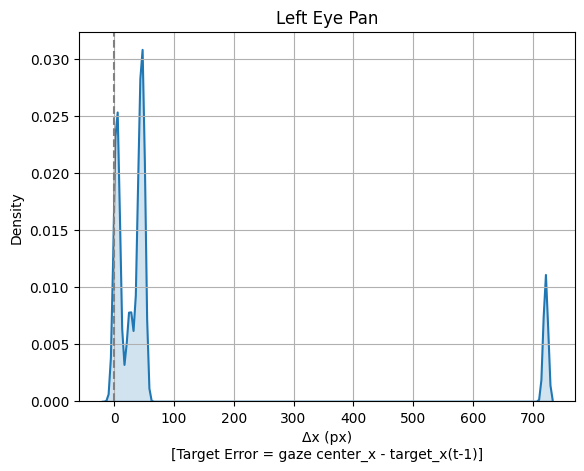

In [14]:
# Showing the whole plot
sns.kdeplot(-pickle_df['dx_l'], fill=True,alpha=.2, linewidth=1.5, bw_adjust=0.1)
plt.axvline(0, color='gray', linestyle='--')
plt.grid()
plt.xlabel('Δx (px)\n[Target Error = gaze center_x - target_x(t-1)]')
plt.title('Left Eye Pan')
# Identify why dx_l and dx_r are different

Text(0.5, 1.0, 'Left Eye Pan')

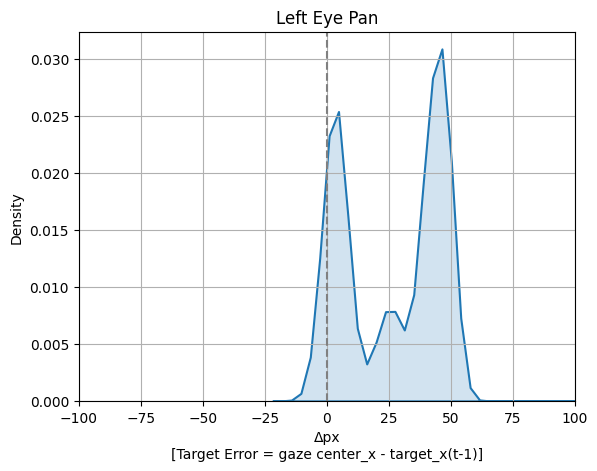

In [15]:
# Zoomed In Graph
sns.kdeplot(-pickle_df['dx_l'], fill=True,alpha=.2, linewidth=1.5, bw_adjust=0.1)
plt.xlim([-100,100])
plt.axvline(0, color='gray', linestyle='--')
plt.grid()
plt.xlabel('Δpx\n[Target Error = gaze center_x - target_x(t-1)]')
plt.title('Left Eye Pan')

### Right Eye Pan

Text(0.5, 1.0, 'Right Eye Pan')

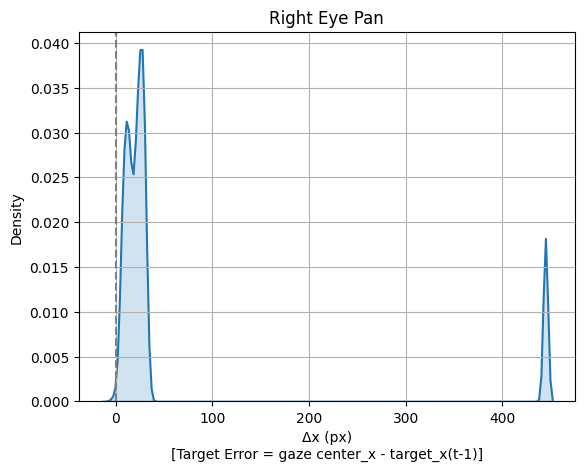

In [16]:
# Showing the whole plot
sns.kdeplot(-pickle_df['dx_r'], fill=True,alpha=.2, linewidth=1.5, bw_adjust=0.1)
plt.axvline(0, color='gray', linestyle='--')
plt.grid()
plt.xlabel('Δx (px)\n[Target Error = gaze center_x - target_x(t-1)]')
plt.title('Right Eye Pan')

Text(0.5, 1.0, 'Right Eye Pan')

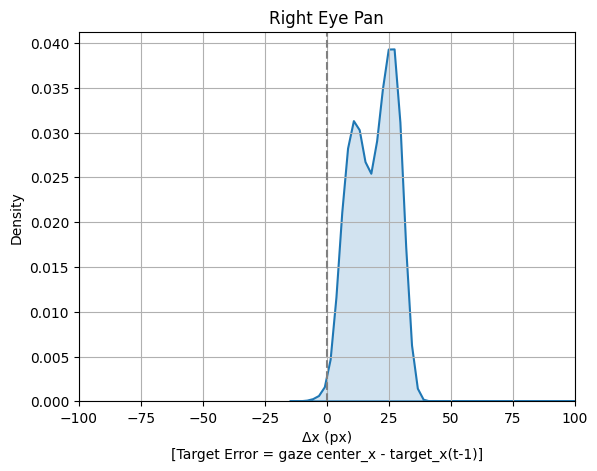

In [17]:
# Zoomed In Graph
sns.kdeplot(-pickle_df['dx_r'], fill=True,alpha=.2, linewidth=1.5, bw_adjust=0.1)
plt.xlim([-100,100])
plt.axvline(0, color='gray', linestyle='--')
plt.grid()
plt.xlabel('Δx (px)\n[Target Error = gaze center_x - target_x(t-1)]')
plt.title('Right Eye Pan')

### Eyes Tilt (Left)

Text(0.5, 1.0, 'Eyes Tilt (Left Camera)')

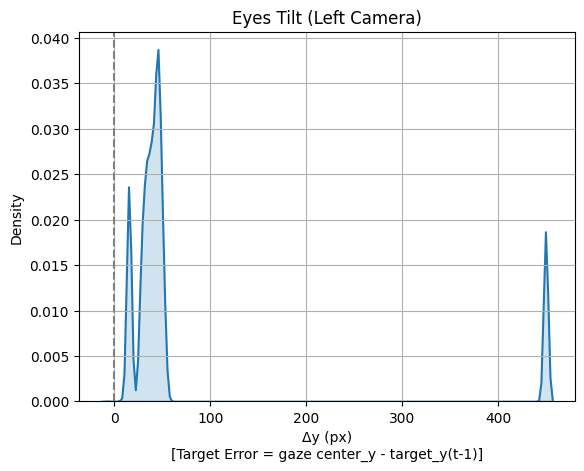

In [18]:
# Showing the whole plot
sns.kdeplot(pickle_df['dy_l'], fill=True,alpha=.2, linewidth=1.5, bw_adjust=0.1)
plt.axvline(0, color='gray', linestyle='--')
plt.grid()
plt.xlabel('Δy (px)\n[Target Error = gaze center_y - target_y(t-1)]')
plt.title('Eyes Tilt (Left Camera)')

Positive Δy: Going Down </br>
Negative Δy: Going Up

Text(0.5, 1.0, 'Eyes Tilt (Left)')

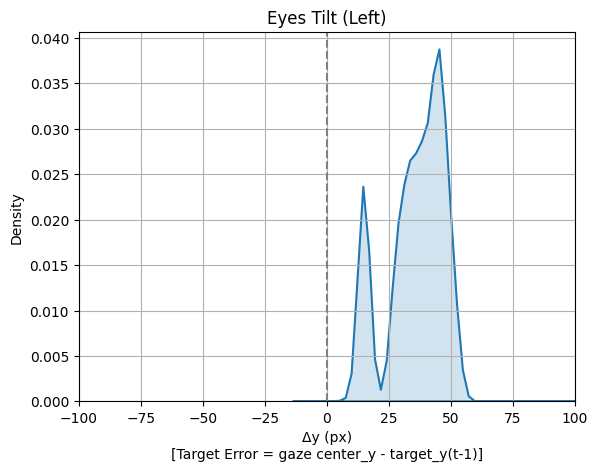

In [19]:
# Showing the whole plot
sns.kdeplot(pickle_df['dy_l'], fill=True,alpha=.2, linewidth=1.5, bw_adjust=0.1)
plt.xlim([-100, 100])
plt.axvline(0, color='gray', linestyle='--')
plt.grid()
plt.xlabel('Δy (px)\n[Target Error = gaze center_y - target_y(t-1)]')
plt.title('Eyes Tilt (Left)')

### Eyes Tilt (Right)

Text(0.5, 1.0, 'Eyes Tilt (Right)')

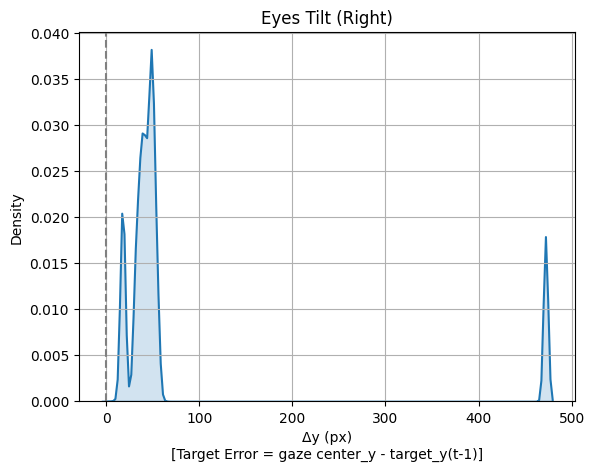

In [20]:
# Showing the whole plot
sns.kdeplot(pickle_df['dy_r'], fill=True,alpha=.2, linewidth=1.5, bw_adjust=0.1)
plt.axvline(0, color='gray', linestyle='--')
plt.grid()
plt.xlabel('Δy (px)\n[Target Error = gaze center_y - target_y(t-1)]')
plt.title('Eyes Tilt (Right)')

Text(0.5, 1.0, 'Eyes Tilt (Right)')

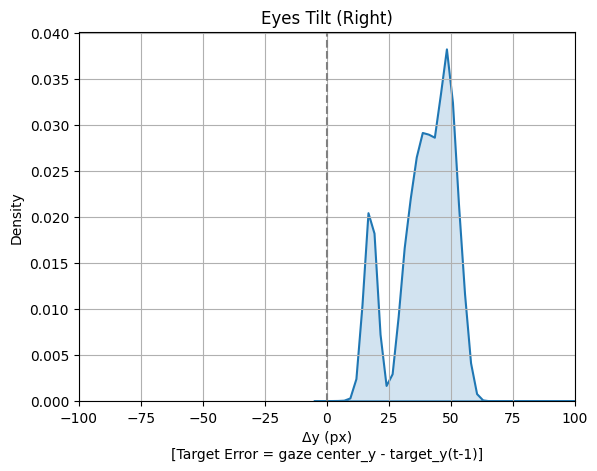

In [21]:
# Showing the whole plot
sns.kdeplot(pickle_df['dy_r'], fill=True,alpha=.2, linewidth=1.5, bw_adjust=0.1)
plt.xlim([-100, 100])
plt.axvline(0, color='gray', linestyle='--')
plt.grid()
plt.xlabel('Δy (px)\n[Target Error = gaze center_y - target_y(t-1)]')
plt.title('Eyes Tilt (Right)')

# Filtering

## Undetected Chessboard

In [22]:
unfilt_df = pickle_df[pickle_df['dx_l']<-200].reset_index(drop=True)
unfilt_df.head()

,chess_idx,theta_left_pan,theta_right_pan,theta_tilt,chest_cam_px_x_tminus1,chest_cam_px_y_tminus1,left_eye_px_x_tminus1,left_eye_px_y_tminus1,right_eye_px_x_tminus1,right_eye_px_y_tminus1,...,theta_tilt_tminus1,plan_phi_left_pan_tminus2,plan_phi_right_pan_tminus2,plan_phi_tilt_tminus2,plan_phi_left_pan_tminus1,plan_phi_right_pan_tminus1,plan_phi_tilt_tminus1,phi_direction_left_pan,phi_direction_right_pan,phi_direction_tilt
0,26,-0.439453,-2.285156,-19.951172,414.386871,156.548782,-360.6,-224.7,-222.3,-235.9,...,-25.927734,-0.213676,-0.264229,-0.177380,-0.000680,-0.056091,-0.136179,1,1,3
1,32,-0.527344,-2.285156,-15.908203,414.397614,156.559647,-360.6,-224.7,-222.3,-235.9,...,-19.951172,-0.000680,-0.056091,-0.136179,-0.008154,-0.058848,-0.109070,2,2,3
2,53,-0.439453,-2.460938,-7.646484,414.020752,106.629257,-360.6,-224.7,-222.3,-235.9,...,-25.927734,-0.171698,-0.224428,-0.177380,-0.001376,-0.057284,-0.052506,1,1,3
3,32,-0.439453,-2.460938,-29.443359,414.746429,231.817078,-360.6,-224.7,-222.3,-235.9,...,-7.646484,-0.001376,-0.057284,-0.052506,-0.003068,-0.060241,-0.257866,2,2,2
4,48,-0.351562,-2.285156,-25.839844,414.485718,181.474518,-360.6,-224.7,-222.3,-235.9,...,-25.927734,-0.295091,-0.343432,-0.177380,0.000504,-0.053627,-0.175743,1,1,3


In [23]:
len(unfilt_df)

586

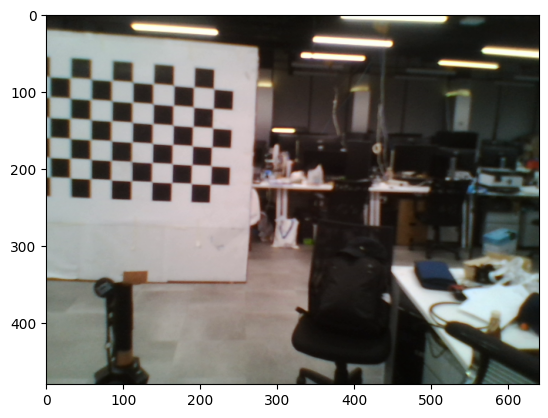

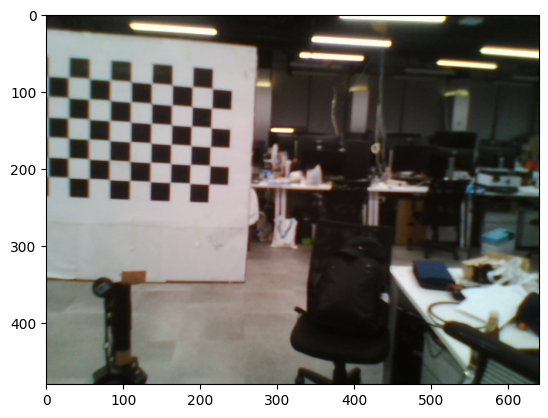

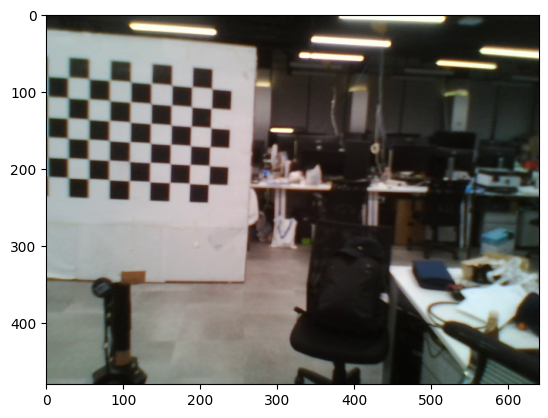

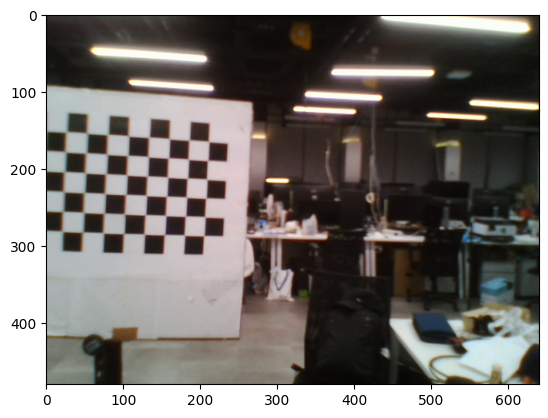

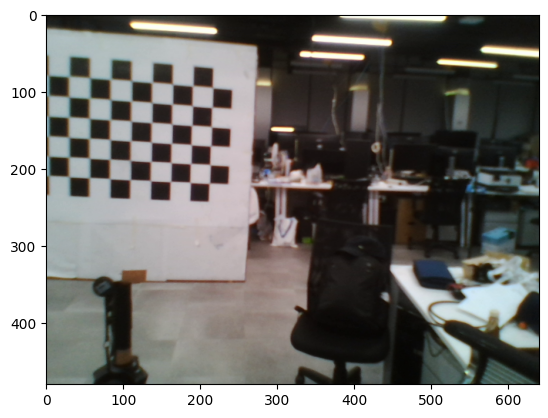

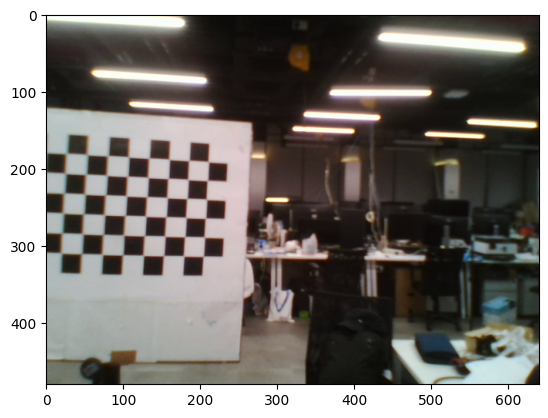

In [24]:
for i in range(400,406):
    img = unfilt_df['right_eye_img'][i]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

## Valid Chessboard Points

In [25]:
filt_df = pickle_df[pickle_df['dx_l']>-200].reset_index(drop=True)
filt_df.head()

,chess_idx,theta_left_pan,theta_right_pan,theta_tilt,chest_cam_px_x_tminus1,chest_cam_px_y_tminus1,left_eye_px_x_tminus1,left_eye_px_y_tminus1,right_eye_px_x_tminus1,right_eye_px_y_tminus1,...,theta_tilt_tminus1,plan_phi_left_pan_tminus2,plan_phi_right_pan_tminus2,plan_phi_tilt_tminus2,plan_phi_left_pan_tminus1,plan_phi_right_pan_tminus1,plan_phi_tilt_tminus1,phi_direction_left_pan,phi_direction_right_pan,phi_direction_tilt
0,28,-9.140625,-10.283203,-16.259766,261.576111,156.462570,350.273438,192.488876,205.223160,200.211395,...,-29.531250,-0.338007,-0.375724,-0.236167,-0.256584,-0.297022,-0.111142,1,1,1
1,30,-10.722656,-11.601562,-22.324219,235.680664,181.883728,328.026031,191.601654,199.878189,199.024612,...,-16.259766,-0.256584,-0.297022,-0.111142,-0.297689,-0.338868,-0.155519,2,2,2
2,28,-7.998047,-9.140625,-25.488281,287.344482,181.693649,358.615173,178.354340,211.162720,185.998856,...,-22.324219,-0.297689,-0.338868,-0.155519,-0.212774,-0.260473,-0.177380,1,1,0
3,43,-10.195312,-11.601562,-25.488281,235.638321,181.862686,319.226013,178.327484,200.575577,185.577087,...,-25.488281,-0.212774,-0.260473,-0.177380,-0.294543,-0.341015,-0.177380,2,2,1
4,49,-1.845703,-3.867188,-29.443359,389.393799,206.671722,358.246002,186.177155,214.107529,195.302795,...,-25.488281,-0.294543,-0.341015,-0.177380,-0.042108,-0.095335,-0.217981,1,1,2


# Multicolor All Directions Histogram

## Left Eye

In [26]:
# If plan cmd

# Variable Assignment
theta = 'plan_phi_left_pan_tminus1'
theta_tminus1 = 'plan_phi_left_pan_tminus2'
data = filt_df

# Calculation
left_left_p = [i for i in range(1,len(data[theta_tminus1])) if data[theta][i-1]<data[theta_tminus1][i-1]
                and data[theta][i]<data[theta_tminus1][i]]
left_right_p = [i for i in range(1,len(data[theta_tminus1])) if data[theta][i-1]<data[theta_tminus1][i-1] 
               and data[theta][i]>=data[theta_tminus1][i]]
right_left_p = [i for i in range(1,len(data[theta_tminus1])) if data[theta][i-1]>=data[theta_tminus1][i-1] 
               and data[theta][i]<data[theta_tminus1][i]]
right_right_p = [i for i in range(1,len(data[theta_tminus1])) if data[theta][i-1]>=data[theta_tminus1][i-1] 
               and data[theta][i]>=data[theta_tminus1][i]]

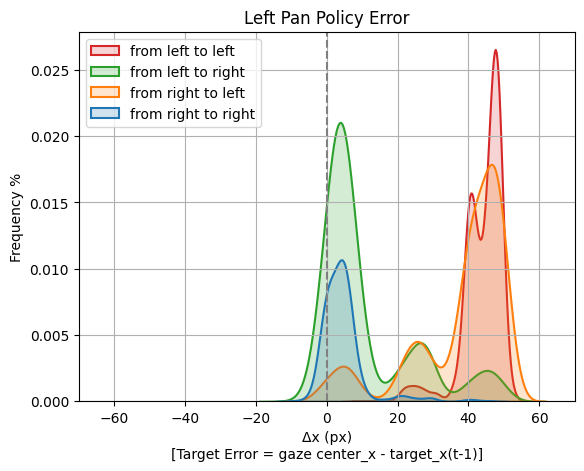

In [27]:
# Pixel Zoomed In

dx = 'dx_l'

# From left to left
new_delta_x_arr1 = -np.array(data[dx])[left_left_p]

# From left to right
new_delta_x_arr2 = -np.array(data[dx])[left_right_p]

# From right to left
new_delta_x_arr3 = -np.array(data[dx])[right_left_p]

# From right to right
new_delta_x_arr4 = -np.array(data[dx])[right_right_p]

sns.kdeplot([new_delta_x_arr4, new_delta_x_arr3, new_delta_x_arr2, new_delta_x_arr1], fill=True,alpha=.2, linewidth=1.5, bw_adjust=1.0)
plt.legend(['from left to left','from left to right','from right to left','from right to right'], loc='upper left')
plt.axvline(0, color='gray', linestyle='--')
plt.xlim([-70,70])
plt.title("Left Pan Policy Error")
plt.xlabel('Δx (px)\n[Target Error = gaze center_x - target_x(t-1)]')
plt.ylabel('Frequency %')
plt.grid()

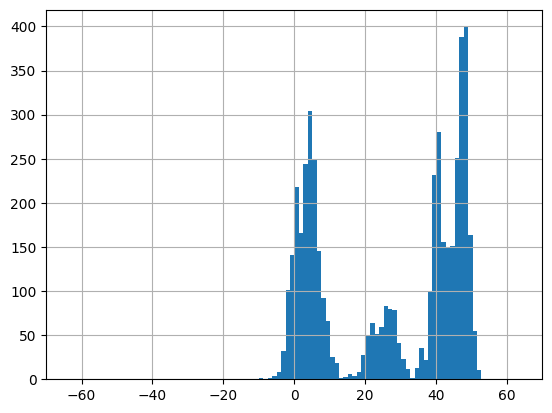

In [28]:
plt.hist(-data[dx], bins=50)
plt.xlim([-70,70])
plt.grid()

## Right Eye

In [29]:
# If plan cmd

# Variable Assignment
theta = 'plan_phi_right_pan_tminus1'
theta_tminus1 = 'plan_phi_right_pan_tminus2'
data = filt_df

# Calculation
left_left_p = [i for i in range(1,len(data[theta_tminus1])) if data[theta][i-1]<data[theta_tminus1][i-1]
                and data[theta][i]<data[theta_tminus1][i]]
left_right_p = [i for i in range(1,len(data[theta_tminus1])) if data[theta][i-1]<data[theta_tminus1][i-1] 
               and data[theta][i]>=data[theta_tminus1][i]]
right_left_p = [i for i in range(1,len(data[theta_tminus1])) if data[theta][i-1]>=data[theta_tminus1][i-1] 
               and data[theta][i]<data[theta_tminus1][i]]
right_right_p = [i for i in range(1,len(data[theta_tminus1])) if data[theta][i-1]>=data[theta_tminus1][i-1] 
               and data[theta][i]>=data[theta_tminus1][i]]

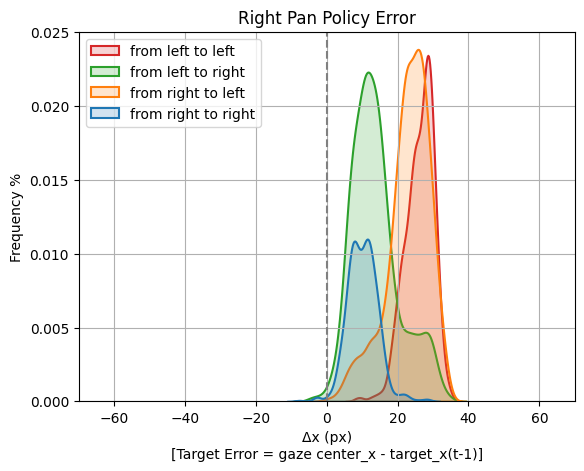

In [30]:
# Pixel Zoomed In

dx = 'dx_r'

# From left to left
new_delta_x_arr1 = -np.array(data[dx])[left_left_p]

# From left to right
new_delta_x_arr2 = -np.array(data[dx])[left_right_p]

# From right to left
new_delta_x_arr3 = -np.array(data[dx])[right_left_p]

# From right to right
new_delta_x_arr4 = -np.array(data[dx])[right_right_p]

sns.kdeplot([new_delta_x_arr4, new_delta_x_arr3, new_delta_x_arr2, new_delta_x_arr1], fill=True,alpha=.2, linewidth=1.5, bw_adjust=1.0)
plt.legend(['from left to left','from left to right','from right to left','from right to right'], loc='upper left')
plt.axvline(0, color='gray', linestyle='--')
plt.xlim([-70,70])
plt.title("Right Pan Policy Error")
plt.xlabel('Δx (px)\n[Target Error = gaze center_x - target_x(t-1)]')
plt.ylabel('Frequency %')
plt.grid()

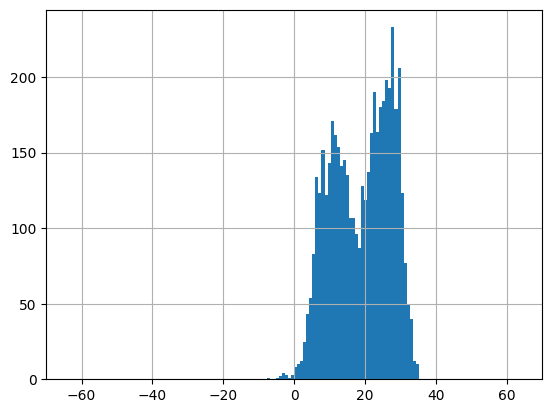

In [31]:
plt.hist(-data[dx], bins=50)
plt.xlim([-70,70])
plt.grid()

## Eyes Tilt (Left)

In [32]:
# If plan cmd

# Variable Assignment
theta = 'plan_phi_tilt_tminus1'
theta_tminus1 = 'plan_phi_tilt_tminus2'
data = filt_df

# Calculation
down_down_p = [i for i in range(1,len(data[theta_tminus1])) if data[theta][i-1]<data[theta_tminus1][i-1]
                and data[theta][i]<data[theta_tminus1][i]]
down_up_p = [i for i in range(1,len(data[theta_tminus1])) if data[theta][i-1]<data[theta_tminus1][i-1] 
               and data[theta][i]>=data[theta_tminus1][i]]
up_down_p = [i for i in range(1,len(data[theta_tminus1])) if data[theta][i-1]>=data[theta_tminus1][i-1] 
               and data[theta][i]<data[theta_tminus1][i]]
up_up_p = [i for i in range(1,len(data[theta_tminus1])) if data[theta][i-1]>=data[theta_tminus1][i-1] 
               and data[theta][i]>=data[theta_tminus1][i]]

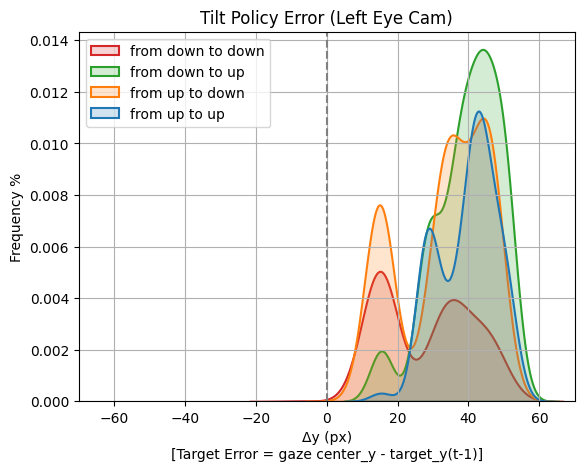

In [33]:
# Pixel Zoomed In

dx = 'dy_l'

# From down to down
new_delta_x_arr1 = np.array(data[dx])[down_down_p]

# From down to up
new_delta_x_arr2 = np.array(data[dx])[down_up_p]

# From up to down
new_delta_x_arr3 = np.array(data[dx])[up_down_p]

# From up to up
new_delta_x_arr4 = np.array(data[dx])[up_up_p]

sns.kdeplot([new_delta_x_arr4, new_delta_x_arr3, new_delta_x_arr2, new_delta_x_arr1], fill=True,alpha=.2, linewidth=1.5, bw_adjust=1.5)
plt.legend(['from down to down','from down to up','from up to down','from up to up'], loc='upper left')
plt.axvline(0, color='gray', linestyle='--')
plt.xlim([-70,70])
plt.title("Tilt Policy Error (Left Eye Cam)")
plt.xlabel('Δy (px)\n[Target Error = gaze center_y - target_y(t-1)]')
plt.ylabel('Frequency %')
plt.grid()

Positive Δy: Going Down </br>
Negative Δy: Going Up

## Eyes Tilt (Right)

In [34]:
# If plan cmd

# Variable Assignment
theta = 'plan_phi_tilt_tminus1'
theta_tminus1 = 'plan_phi_tilt_tminus2'
data = filt_df

# Calculation
down_down_p = [i for i in range(1,len(data[theta_tminus1])) if data[theta][i-1]<data[theta_tminus1][i-1]
                and data[theta][i]<data[theta_tminus1][i]]
down_up_p = [i for i in range(1,len(data[theta_tminus1])) if data[theta][i-1]<data[theta_tminus1][i-1] 
               and data[theta][i]>=data[theta_tminus1][i]]
up_down_p = [i for i in range(1,len(data[theta_tminus1])) if data[theta][i-1]>=data[theta_tminus1][i-1] 
               and data[theta][i]<data[theta_tminus1][i]]
up_up_p = [i for i in range(1,len(data[theta_tminus1])) if data[theta][i-1]>=data[theta_tminus1][i-1] 
               and data[theta][i]>=data[theta_tminus1][i]]

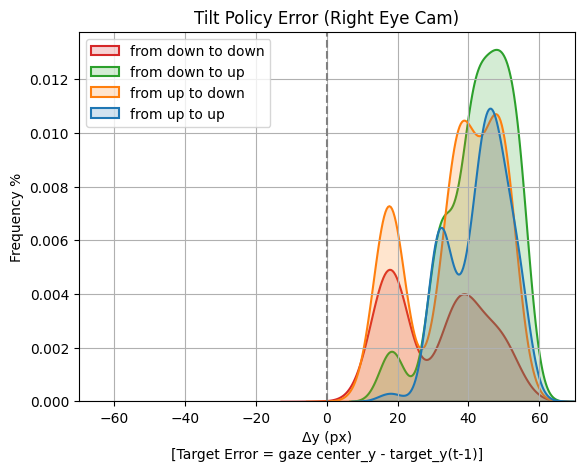

In [35]:
# Pixel Zoomed In

dx = 'dy_r'

# From down to down
new_delta_x_arr1 = np.array(data[dx])[down_down_p]

# From down to up
new_delta_x_arr2 = np.array(data[dx])[down_up_p]

# From up to down
new_delta_x_arr3 = np.array(data[dx])[up_down_p]

# From up to up
new_delta_x_arr4 = np.array(data[dx])[up_up_p]

sns.kdeplot([new_delta_x_arr4, new_delta_x_arr3, new_delta_x_arr2, new_delta_x_arr1], fill=True,alpha=.2, linewidth=1.5, bw_adjust=1.5)
plt.legend(['from down to down','from down to up','from up to down','from up to up'], loc='upper left')
plt.axvline(0, color='gray', linestyle='--')
plt.xlim([-70,70])
plt.title("Tilt Policy Error (Right Eye Cam)")
plt.xlabel('Δy (px)\n[Target Error = gaze center_y - target_y(t-1)]')
plt.ylabel('Frequency %')
plt.grid()

Positive Δy: Going Down </br>
Negative Δy: Going Up

# Whole Scatter Plot

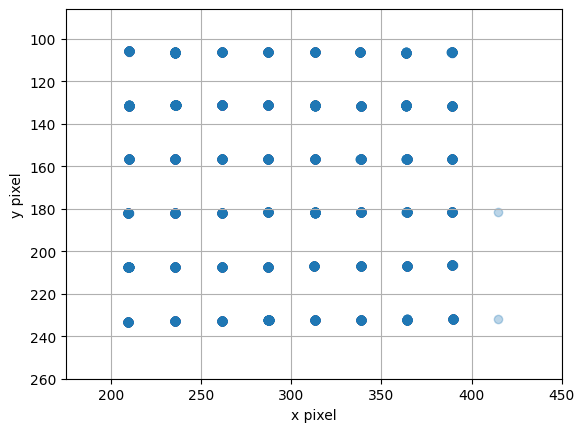

In [36]:
plt.scatter(filt_df['chest_cam_px_x_tminus1'], filt_df['chest_cam_px_y_tminus1'], alpha=0.3)
plt.xlim([175, 450])
plt.ylim([260, 86])
plt.xlabel('x pixel')
plt.ylabel('y pixel')
plt.grid()

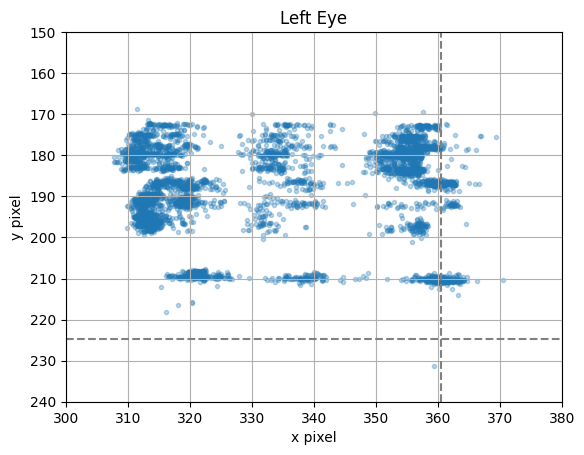

In [37]:
plt.scatter(filt_df['left_eye_px_x_tminus1'], filt_df['left_eye_px_y_tminus1'], marker='.', alpha=0.3)
plt.xlim([300, 380])
plt.ylim([240, 150])
plt.axvline(calib_params['left_eye']['x_center'], color='gray', linestyle='--')
plt.axhline(calib_params['left_eye']['y_center'], color='gray', linestyle='--')
plt.xlabel('x pixel')
plt.ylabel('y pixel')
plt.title('Left Eye')
plt.grid()

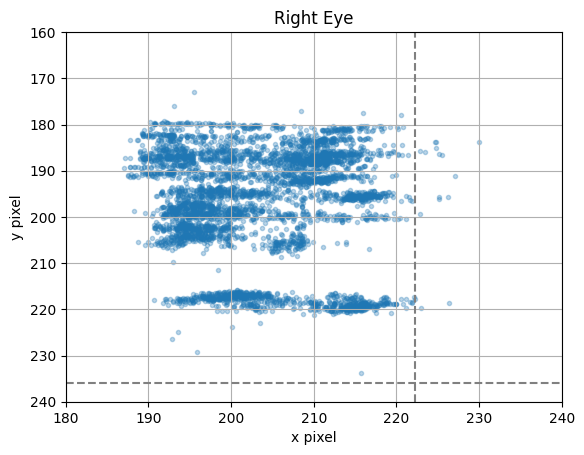

In [38]:
plt.scatter(filt_df['right_eye_px_x_tminus1'], filt_df['right_eye_px_y_tminus1'], marker='.', alpha=0.3)
plt.xlim([180, 240])
plt.ylim([240, 160])
plt.axvline(calib_params['right_eye']['x_center'], color='gray', linestyle='--')
plt.axhline(calib_params['right_eye']['y_center'], color='gray', linestyle='--')
plt.xlabel('x pixel')
plt.ylabel('y pixel')
plt.title('Right Eye')
plt.grid()

# Individual Chess Point Scatter Plot

## Left Eye

In [39]:
# Looping for Policy Plot

# Data
data = filt_df
dx = 'dx_l'
dy = 'dy_l'

delta_x_list = []
delta_y_list = []
for chess_idx in range(54):
    idxs = [i for i,val in enumerate(data['chess_idx_tminus1']) if val==chess_idx]
    after_px_x = np.array([data[dx][i] for i in idxs])
    after_px_y = np.array([data[dy][i] for i in idxs])
    delta_x_list.append(after_px_x)
    delta_y_list.append(after_px_y)

/home/jaynieles/dev/aec/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/jaynieles/dev/aec/venv/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_18094/4002526793.py:43: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(x, y)
/home/jaynieles/dev/aec/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/jaynieles/dev/aec/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/jaynieles/dev/aec/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jaynieles/dev/aec/venv/lib/python3.

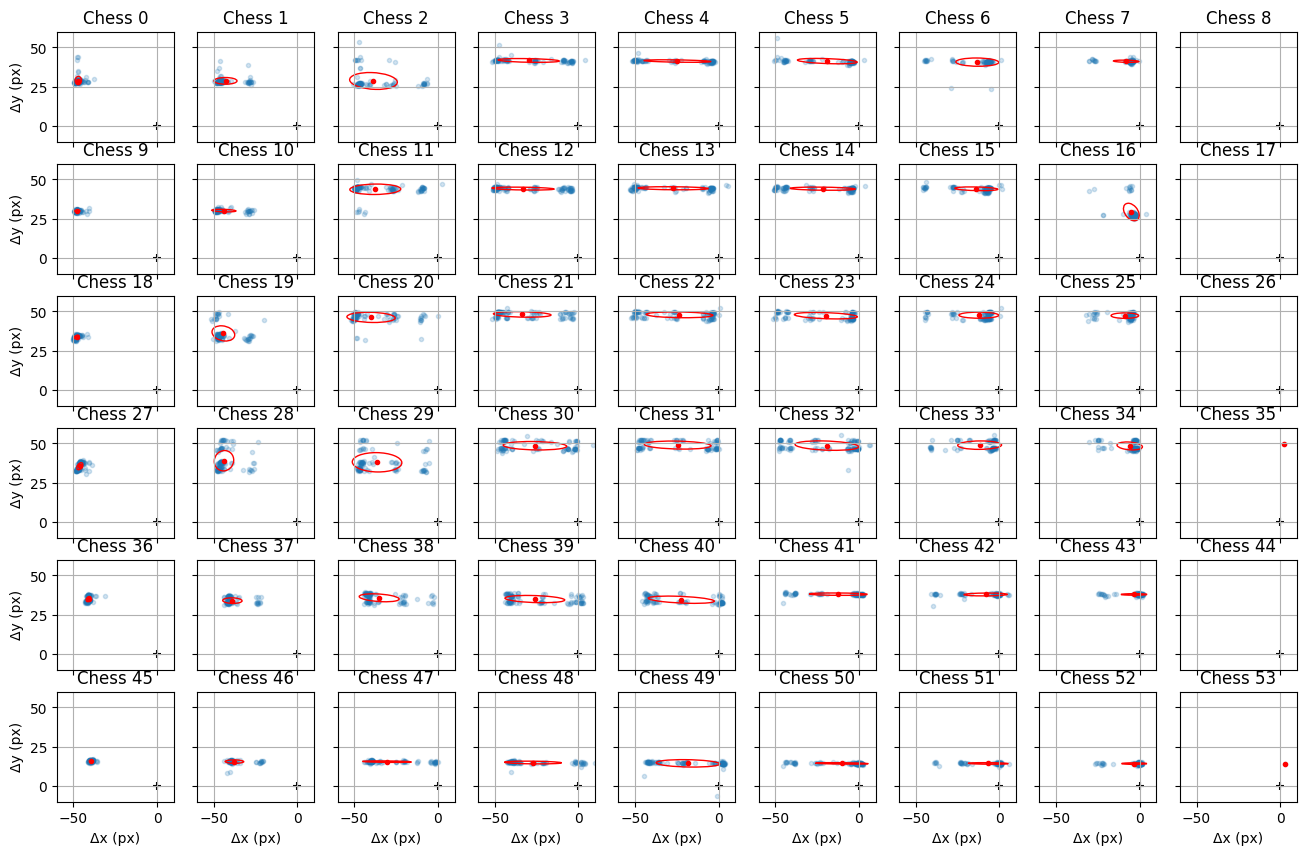

In [40]:
# Scatter Plot

fig, axs = plt.subplots(6, 9, figsize=(16,10))
for i,ax_i in enumerate(axs.flat):
    ax_i.scatter(delta_x_list[i], delta_y_list[i], marker='.', color='#1f77b4', alpha=0.2)
    confidence_ellipse(x=delta_x_list[i], y=delta_y_list[i], ax=ax_i, n_std=1.0, edgecolor='red')
    ax_i.scatter(delta_x_list[i].mean(), delta_y_list[i].mean(), marker='.', color='red')
    ax_i.scatter(0, 0, marker='+', color='black')
    ax_i.set_xlim(-60, 10)
    ax_i.set_ylim(-10, 60)
    ax_i.set_title('Chess %i' % (i))
    ax_i.grid(True)

for ax in axs.flat:
    ax.set(xlabel='Δx (px)', ylabel='Δy (px)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

## Right Eye

In [41]:
# Looping for Policy Plot

# Data
data = filt_df
dx = 'dx_r'
dy = 'dy_r'

delta_x_list = []
delta_y_list = []
for chess_idx in range(54):
    idxs = [i for i,val in enumerate(data['chess_idx_tminus1']) if val==chess_idx]
    after_px_x = np.array([data[dx][i] for i in idxs])
    after_px_y = np.array([data[dy][i] for i in idxs])
    delta_x_list.append(after_px_x)
    delta_y_list.append(after_px_y)

/tmp/ipykernel_18094/4002526793.py:43: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(x, y)
/tmp/ipykernel_18094/4154314164.py:7: RuntimeWarning: Mean of empty slice.
  ax_i.scatter(delta_x_list[i].mean(), delta_y_list[i].mean(), marker='.', color='red')


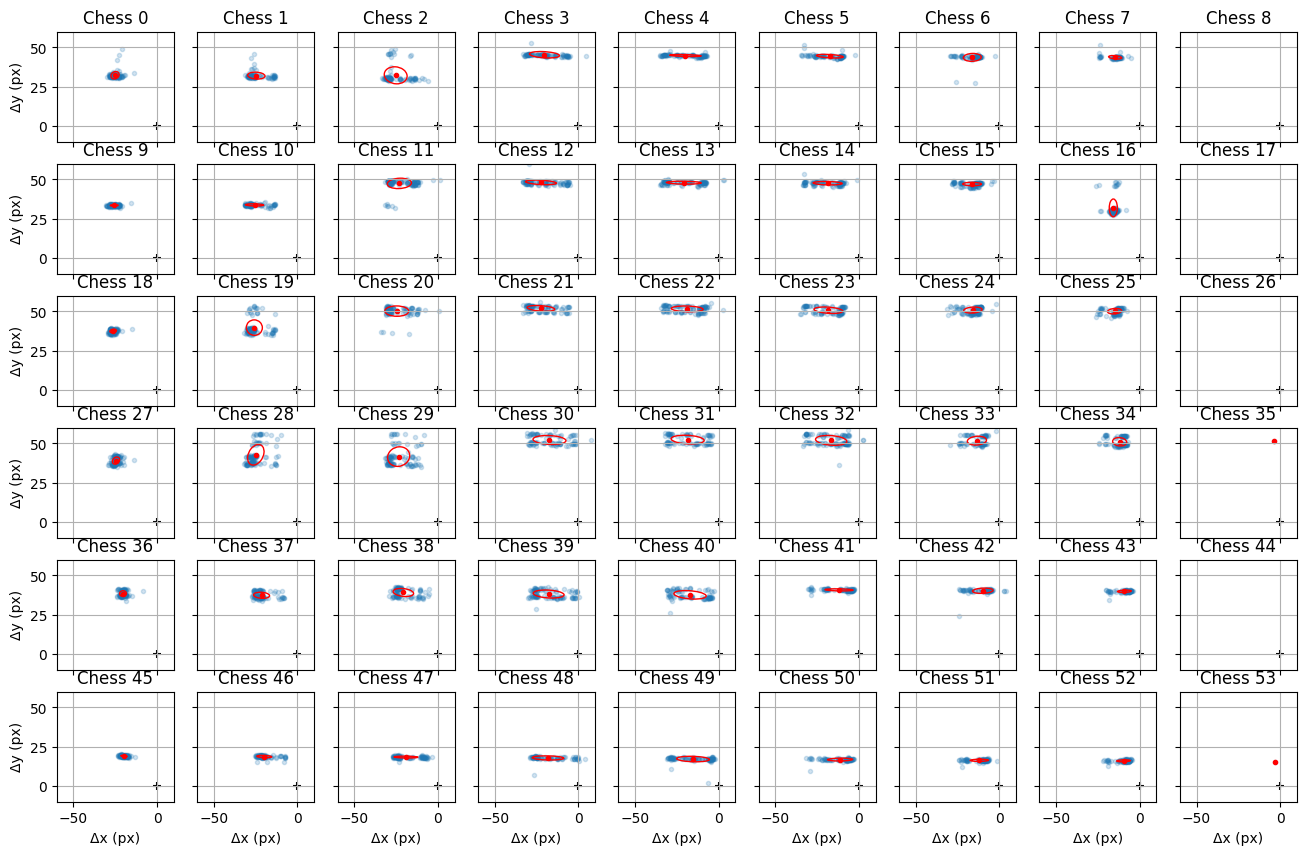

In [42]:
# Scatter Plot

fig, axs = plt.subplots(6, 9, figsize=(16,10))
for i,ax_i in enumerate(axs.flat):
    ax_i.scatter(delta_x_list[i], delta_y_list[i], marker='.', color='#1f77b4', alpha=0.2)
    confidence_ellipse(x=delta_x_list[i], y=delta_y_list[i], ax=ax_i, n_std=1.0, edgecolor='red')
    ax_i.scatter(delta_x_list[i].mean(), delta_y_list[i].mean(), marker='.', color='red')
    ax_i.scatter(0, 0, marker='+', color='black')
    ax_i.set_xlim(-60, 10)
    ax_i.set_ylim(-10, 60)
    ax_i.set_title('Chess %i' % (i))
    ax_i.grid(True)

for ax in axs.flat:
    ax.set(xlabel='Δx (px)', ylabel='Δy (px)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# Individual Histograms

## Eyes Tilt (Left) [Chesspoint = 40]

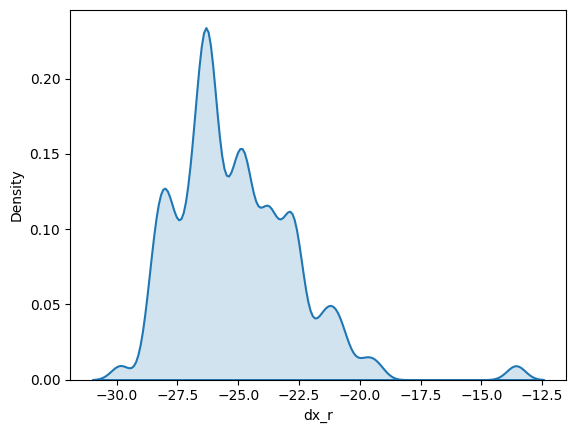

(array([ 8., 22., 34., 25., 15.,  7.,  2.,  0.,  0.,  1.]),
 array([-29.85749512, -28.22985535, -26.60221558, -24.97457581,
        -23.34693604, -21.71929626, -20.09165649, -18.46401672,
        -16.83637695, -15.20873718, -13.58109741]),
 <BarContainer object of 10 artists>)

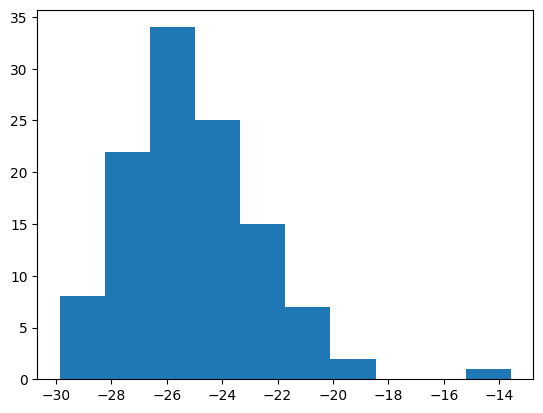

In [43]:
# If plan cmd

# Variable Assignment
theta = 'plan_phi_tilt_tminus1'
theta_tminus1 = 'plan_phi_tilt_tminus2'
data = filt_df[filt_df['chess_idx_tminus1']==0].reset_index(drop=True)

# Plot
sns.kdeplot(data[dx], fill=True,alpha=.2, linewidth=1.5, bw_adjust=0.4)
plt.show()
plt.hist(data[dx])